In [1]:
import torch
import gym
import numpy as np

from gym_atom_array.env import ArrayEnv, Config

## Specify exp name and model version

In [2]:
wandb_name = "run-20230130_143317-l09u3ob3"
model_version = "final"

model_path = f"wandb/{wandb_name}/files/agent-{model_version}.pt"

## Configure environment and load model

In [3]:
from argparse import Namespace
from clean_agents.ppo import Agent, make_env

args = Namespace(Render=False, ArraySize=5, DefaultPenalty=-0.1, TargetPickUp=-5, TargetRelease=10, TimeLimit=200)
envs = gym.vector.SyncVectorEnv(
    [make_env(1, args),]
)

In [4]:
agent = Agent(envs)
state_dict = torch.load(model_path)
agent.load_state_dict(state_dict)

agent.eval()

Agent(
  (extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=288, out_features=64, bias=True)
    (6): ReLU()
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=288, out_features=64, bias=True)
      (6): ReLU()
    )
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Tanh()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1

# Start visualization

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [6]:
%matplotlib notebook

In [10]:
def obs_to_plots(obs, atoms_plt, mt_plt):
    atom_grid, tar_grid, mt_grid = obs[0]
    
    dots = [[], []]
    mt_pos = (0, 0)
    for i in range(n):
        for j in range(n):
            if mt_grid[i, j] != 0:
                mt_pos = (i, j, mt_grid[i, j])
            if atom_grid[i, j] == 1:
                dots[0].append(i)
                dots[1].append(j)
    print(obs)
    atoms_plt.set_data(dots)
    mt_plt.set_data(mt_pos[0], mt_pos[1])
    mt_plt.set_marker('x' if mt_pos[2] == 1 else 'o')
    
    return atoms_plt, mt_plt

In [11]:
fig, ax = plt.subplots()

n = args.ArraySize
ax.set_xlim(-1, n)
ax.set_ylim(-1, n)

obs = envs.reset()
atom_grid, tar_grid, mt_grid = obs[0]
dots = [[], []]
for i in range(n):
    for j in range(n):
        if tar_grid[i, j] == 1:
            dots[0].append(i)
            dots[1].append(j)

targets, = ax.plot(dots[0], dots[1], 'gs', markersize=12, markerfacecolor=(1, 1, 0, 0.5))
atoms, = ax.plot([], [], 'bo')
mt, = ax.plot(0, 0, 'ro', markersize=10)

# obs_to_plots(obs, atoms, mt)

next_obs = torch.Tensor(obs)
done = False
def animate(frame_num):    
    if done[0]:
        ax.set_title("boobler")
        return None
    
    ax.set_title("boobler")
    with torch.no_grad():
        action, logprob, _, _ = agent.get_action_and_value(next_obs)
        
    next_obs, reward, done, info = envs.step(action.cpu().numpy())
    print(next_obs)
    atoms, mt = obs_to_plots(next_obs, atoms, mt)
    
    next_obs = torch.Tensor(next_obs)
    done = [done,]
    return (atoms, mt)

anim = FuncAnimation(fig, animate, frames=5, interval=1000, blit=True)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


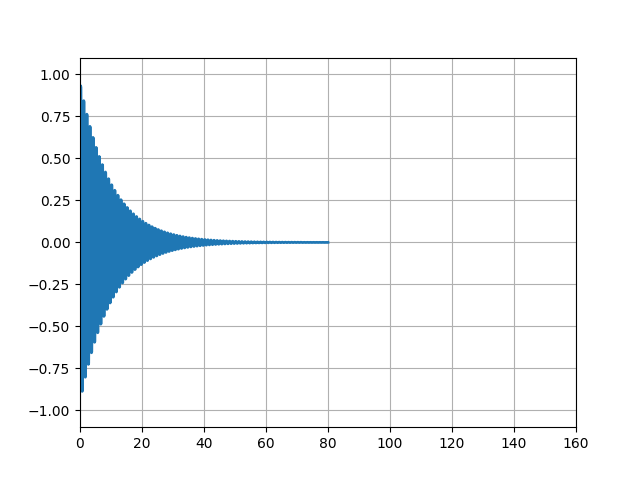

In [9]:
def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
plt.show()

In [5]:
import time

In [10]:
start = time.time_ns()

next_obs = envs.reset()
next_obs = torch.Tensor(next_obs)

with torch.no_grad():
    i = 0
    done = False
    while not done and i < args.TimeLimit:
        action, logprob, _, _ = agent.get_action_and_value(next_obs)
        
        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        next_obs = torch.Tensor(next_obs)
        i += 1
        
end = time.time_ns()
print((end - start) / 10**6, i)

9.992095 21


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [136]:
obs1 = torch.tensor([[[0,1,1,1,1],[0,1,1,1,1],[1,0,1,0,1],[0,1,1,0,0],[1,0,1,1,0]],[[0,0,0,0,0],[0,1,1,1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,1],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])
obs2 = torch.tensor([[[0,1,1,1,1],[0,1,1,1,1],[1,0,1,0,1],[0,1,1,0,0],[1,0,1,1,0]],[[0,0,0,0,0],[0,1,1,1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,2],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])

batch = torch.tensor((obs1.numpy(), obs2.numpy()))

In [138]:
kernel = torch.tensor([[[[0, 1000, 0],[10, 0, 1],[0, 100, 0]],  [[0, 0, 0],[0, 0, 0],[0, 0, 0]],  [[0, 0, 0],[0, 10000, 0],[0, 0, 0]]]])


In [152]:
has_atoms = torch.amax(batch, (1, 2, 3))

padded = F.pad(batch, (1,)*4, value=2)
detect = F.conv2d(padded, kernel)
inter_masks = torch.amax(detect, (1, 2, 3))

inter_masks = inter_masks + inter_masks * (has_atoms == 2)
masks_ = torch.stack((
    inter_masks % 10000 < 2000,
    inter_masks % 1000 < 200,
    inter_masks % 100 < 20,
    inter_masks % 10 < 2,
    has_atoms == 1,
    has_atoms == 2
))

In [153]:
masks_.T

tensor([[ True,  True,  True, False,  True, False],
        [False, False, False, False, False,  True]])

In [148]:
outer_masks

tensor([11112, 42224])

In [129]:
has_atoms

tensor([1, 2])

In [116]:
obs

tensor([[[0, 1, 1, 1, 1],
         [0, 1, 1, 1, 1],
         [1, 0, 1, 0, 1],
         [0, 1, 1, 0, 0],
         [1, 0, 1, 1, 0]],

        [[0, 0, 0, 0, 0],
         [0, 1, 1, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]])

In [60]:
torch.amax(obs, 2)

tensor([[1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [77]:
batch = torch.tensor((obs.numpy(), obs.numpy()*2))
has_atom = torch.amax(batch, (1, 2, 3))
has_atom == 1, has_atom == 2

(tensor([ True, False]), tensor([False,  True]))

In [111]:
batch.shape

torch.Size([2, 3, 5, 5])